<a href="https://colab.research.google.com/github/EmaMule/Computer-Vision/blob/main/CVUSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Abstract

The task of **Ground-to-Aerial matching** caught our attention for several reasons.

Primarily, we were intrigued to delve into our first work in the field of Information Retrieval and multi-view and cross-domain image analysis. The prospect of addressing a novel challenge within this domain was exciting and offered the opportunity to contribute meaningfully to the development of new methodologies and technologies.

Additionally, the challenge of matching a ground image to the correct satellite image without any spatial information (such as coordinates where the picture was taken) presented a fascinating problem. The complexity of this problem lies in the significant differences in scale, angle, and appearance between ground-level and aerial images, necessitating advanced algorithms and innovative approaches to bridge the gap.

Following the **feature-enrichment approach** of the [paper](https://arxiv.org/html/2404.11302v1) "A Semantic Segmentation-guided Approach for Ground-to-Aerial Image Matching", we present an enriched dataset, starting from a subset of the CVUSA dataset, and new models combining brand new features (such as Ground Depth estimation and Ground Semantic Segmentation), with the ones presented in the paper.

As **backbone models** for our "branches" we used most of the state of the art models, in particular VGG16, ResNet (in the 50, 101 and 152 versions) and SAIG, a transformer-based model for dealing that proved to be [quite effective](https://arxiv.org/abs/2302.01572).

The generation of the new features was done in two different Colab notebooks:


*   [Ground Depth Estimation](https://colab.research.google.com/drive/1FzAKRESCVgZdi3U21maYJardy_BZ2Qx6?usp=drive_link)
*   [Ground Semantic Segmentation](https://colab.research.google.com/drive/1Mu0SlsxwE-nl9W5rOCQCxvP7UQ-AITN6?usp=drive_link)

Everything was done using **Pytorch Lightning**.

#Import and installing dependencies

In [1]:
%%capture

# @title Installing dependencies

!pip install tqdm
!pip install pytorch_lightning
!pip install patool
!pip install torchvision nightly

In [2]:
# @title Importing libraries

import pandas as pd
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
from google.colab import drive
import shutil
import csv
import cv2
import gdown
import patoolib
import inspect
from typing_extensions import override
from sys import version
import abc

# pytorch
import torch
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler, RandomSampler, BatchSampler
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import v2
from torchmetrics.functional.pairwise import pairwise_cosine_similarity

# pytorch lighting
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar, RichProgressBar, ModelPruning
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers.logger import Logger

In [3]:
# @title Folders Setup

shutil.rmtree('/content/input', ignore_errors = True)
os.mkdir('/content/input')

shutil.rmtree('/content/output', ignore_errors = True)
os.mkdir('/content/output')

shutil.rmtree('/content/output/log', ignore_errors = True)
os.mkdir('/content/output/log')

shutil.rmtree('/content/lightning_logs', ignore_errors = True)
os.mkdir('/content/lightning_logs')

In [4]:
# @title Downloading Dataset from our Google Drive

# subset: 1-FHbO02_KtJcStojzf1JRKwJkc0hMCLd
# subset 2.0 : 11DR7zhd6wchdyt8DSkTY2JGgf_jrtf1D

url = 'https://drive.google.com/uc?id=11DR7zhd6wchdyt8DSkTY2JGgf_jrtf1D'
output_file = '/content/input/CVUSA_subset_2_0.rar'
output_dir = '/content/input/data'

gdown.download(url, output_file)
patoolib.extract_archive(output_file, outdir = output_dir)


Downloading...
From (original): https://drive.google.com/uc?id=11DR7zhd6wchdyt8DSkTY2JGgf_jrtf1D
From (redirected): https://drive.google.com/uc?id=11DR7zhd6wchdyt8DSkTY2JGgf_jrtf1D&confirm=t&uuid=d93f75f0-cbee-4a7c-86ef-bea6136fe057
To: /content/input/CVUSA_subset_2_0.rar
100%|██████████| 4.65G/4.65G [01:31<00:00, 51.1MB/s]
INFO patool: Extracting /content/input/CVUSA_subset_2_0.rar ...
INFO:patool:Extracting /content/input/CVUSA_subset_2_0.rar ...
INFO patool: ... creating output directory `/content/input/data'.
INFO:patool:... creating output directory `/content/input/data'.
INFO patool: running /usr/bin/7z x -o/content/input/data -- /content/input/CVUSA_subset_2_0.rar
INFO:patool:running /usr/bin/7z x -o/content/input/data -- /content/input/CVUSA_subset_2_0.rar
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/input/CVUSA_subset_2_0.rar extracted to `/content/input/data'.
INFO:patool:... /content/input/CVUSA_subset_2_0.rar extracted to `/content/

'/content/input/data'

In [5]:
# @title Settings

pl.seed_everything(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

INFO:lightning_fabric.utilities.seed:Seed set to 42


#Dataset and DataModule

In this section we define the **CVUSADataset** class and the **CVUSADataModule** class.

CVUSADataset extracts from the train_updated.csv and val_updated.csv the **paths to the images** that we will use during training.

CVUSADataModule instanciates the two splits of the CVUSADataset and provides several possibilities. It deals with:

1.   **Resizing** the various images
2.   **Normalization** of the various images
3.   Definition of the **Dataloaders**
4.   Computation of **mean and standard deviation**









In [6]:
# @title CVUSADataset class definition

# Expected dataset structure: the input_dir contains the split cvs files and a
# subdirectory named 'data' with the CVUSA dataset

class CVUSADataset(Dataset):

    def __init__(self, input_dir, split = 'train', polar = False):
        self.split = split
        self.polar = polar
        self.data = self.load_data(input_dir + f'/{split}.csv')


    def load_data(self, csv_path):
        data = []
        with open(csv_path, 'r') as file:
            csv_reader = csv.reader(file)
            next(csv_reader) #skip header
            for row in csv_reader:
                grd_path = row[1]
                grd_seg_path = row[5]
                grd_depth_path = row[6]
                if self.polar: #If we want to use polar
                   sat_path = row[3]
                   sat_seg_path = row[4]
                else:
                  sat_path = row[0]
                  sat_seg_path = row[2]
                data.append({"grd_path": grd_path, "grd_seg_path": grd_seg_path, "grd_depth_path": grd_depth_path, "sat_path": sat_path, "sat_seg_path": sat_seg_path})

        return data


    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        dictionary = self.data[index]
        grd_path = dictionary['grd_path']
        grd_seg_path = dictionary['grd_seg_path']
        grd_depth_path = dictionary['grd_depth_path']
        sat_path = dictionary['sat_path']
        sat_seg_path = dictionary['sat_seg_path']
        return grd_path, grd_seg_path, grd_depth_path, sat_path, sat_seg_path


    def __str__(self):
        return f"CVUSA-Dataset-{self.split}: {len(self.data)} samples"

In [7]:
# @title CVUSADataModule class definition

class CVUSADataModule(pl.LightningDataModule):

    def __init__(self, input_dir, polar=False, batch_size=8, grd_resize=None, grd_seg_resize=None, grd_depth_resize=None, sat_resize=None, sat_seg_resize=None):
        super(CVUSADataModule, self).__init__()
        self.batch_size = batch_size
        self.input_dir = input_dir
        self.data_dir = input_dir  # + '/data' I made this choice for semplicity!!! """IMPORTANT!!!"
        self.polar = polar

        self.original_size = {'grd': None, 'grd_seg': None, 'grd_depth': None, 'sat': None, 'sat_seg': None}
        self.resize = {'grd': grd_resize, 'grd_seg': grd_seg_resize, 'grd_depth': grd_depth_resize, 'sat': sat_resize, 'sat_seg': sat_seg_resize}
        self.size = {'grd': None, 'grd_seg': None, 'grd_depth': None, 'sat': None, 'sat_seg': None}
        self.mean = {'grd': [0, 0, 0], 'grd_seg': [0, 0, 0], 'grd_depth': [0, 0, 0], 'sat': [0, 0, 0], 'sat_seg': [0, 0, 0]}
        self.std = {'grd': [1, 1, 1], 'grd_seg': [1, 1, 1], 'grd_depth': [1, 1, 1], 'sat': [1, 1, 1], 'sat_seg': [1, 1, 1]}
        self.transform = {'grd': None, 'grd_seg': None, 'grd_depth': None, 'sat': None, 'sat_seg': None}


    def setup(self):
        # load the datasets
        self.train_dataset = CVUSADataset(input_dir=self.input_dir, split='train_updated', polar=self.polar)
        self.val_dataset = CVUSADataset(input_dir=self.input_dir, split='val_updated', polar=self.polar)

        # find image sizes
        self.__compute_image_sizes()

        # compute transforms
        self.__compute_transforms()


    def __compute_image_sizes(self):
        grd_sample, grd_seg_sample, grd_depth_sample, sat_sample, sat_seg_sample = self.train_dataset[0]

        grd_image = v2.ToImage()(Image.open(os.path.join(self.data_dir, grd_sample)))
        grd_seg_image = v2.ToImage()(Image.open(os.path.join(self.data_dir, grd_seg_sample)))
        grd_depth_image = v2.ToImage()(Image.open(os.path.join(self.data_dir, grd_depth_sample)))
        sat_image = v2.ToImage()(Image.open(os.path.join(self.data_dir, sat_sample)))
        sat_seg_image = v2.ToImage()(Image.open(os.path.join(self.data_dir, sat_seg_sample)))

        self.original_size['grd'] = grd_image.size()[1:3]
        self.original_size['grd_seg'] = grd_seg_image.size()[1:3]
        self.original_size['grd_depth'] = grd_depth_image.size()[1:3]
        self.original_size['sat'] = sat_image.size()[1:3]
        self.original_size['sat_seg'] = sat_seg_image.size()[1:3]

        self.size['grd'] = grd_image.size()[1:3]
        self.size['grd_seg'] = grd_seg_image.size()[1:3]
        self.size['grd_depth'] = grd_depth_image.size()[1:3]
        self.size['sat'] = sat_image.size()[1:3]
        self.size['sat_seg'] = sat_seg_image.size()[1:3]

        # compute image new sizes
        for key in self.resize:
            if self.resize[key]:
                image = v2.ToImage()(Image.open(os.path.join(self.data_dir, locals()[f"{key}_sample"])))
                self.size[key] = v2.Resize((self.resize[key]))(image).size()[1:3]


    def __compute_transforms(self):
        for key in self.transform:
            self.transform[key] = v2.Compose([
                v2.ToImage(),
                v2.Resize(self.size[key]),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(self.mean[key], self.std[key], inplace=False)
            ])


    def collate_fn(self, batch):
        grd_path, grd_seg_path, grd_depth_path, sat_path, sat_seg_path = zip(*batch)

        # load and transform each image in the batch
        grd_ids, grd_images = self.__compute_images(grd_path, 'grd')
        grd_seg_ids, grd_seg_images = self.__compute_images(grd_seg_path, 'grd_seg')
        grd_depth_ids, grd_depth_images = self.__compute_images(grd_depth_path, 'grd_depth')
        sat_ids, sat_images = self.__compute_images(sat_path, 'sat')
        sat_seg_ids, sat_seg_images = self.__compute_images(sat_seg_path, 'sat_seg')

        grd_samples = {'imgs': grd_images, 'imgs_id': grd_ids}
        grd_seg_samples = {'imgs': grd_seg_images, 'imgs_id': grd_seg_ids}
        grd_depth_samples = {'imgs': grd_depth_images, 'imgs_id': grd_depth_ids}
        sat_samples = {'imgs': sat_images, 'imgs_id': sat_ids}
        sat_seg_samples = {'imgs': sat_seg_images, 'imgs_id': sat_seg_ids}

        return grd_samples, grd_seg_samples, grd_depth_samples, sat_samples, sat_seg_samples


    def __compute_images(self, paths, img_type):
        images = []
        ids = []

        for img_path in paths:
            img = Image.open(os.path.join(self.data_dir, img_path))
            img = self.transform[img_type](img)
            images.append(img)
            ids.append(int(img_path[-11:-4]))

        # Stack the image tensors along the batch dimension
        images_tensor = torch.stack(images)
        ids_tensor = torch.tensor(ids, dtype=int)
        return ids_tensor, images_tensor


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=True, num_workers=2)


    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=False, num_workers=2)


    def compute_mean_std(self):
        mean_std = {}

        for key in self.mean:
            mean, std = self.__compute_mean_std_for_key(key)
            mean_std[key + '_mean'] = mean
            mean_std[key + '_std'] = std

        return mean_std


    def __compute_mean_std_for_key(self, key):
        mean = np.array([0., 0., 0.])
        std = np.array([0., 0., 0.])

        for i in self.train_dataset.data:
            img_path = os.path.join(self.data_dir, i[f'{key}_path'])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(float) / 255.
            img_size = img.shape[0] * img.shape[1]
            mean += np.mean(img[:, :, :], axis=(0, 1))
            std += ((img[:, :, :] - mean) ** 2).sum(axis=(0, 1)) / img_size

        mean /= len(self.train_dataset.data)
        std = np.sqrt(std / len(self.train_dataset.data))

        return mean, std


    def set_mean_std(self, mean_std):
        for key in self.mean:
            self.mean[key] = mean_std[f'{key}_mean']
            self.std[key] = mean_std[f'{key}_std']

        self.__compute_transforms()

In [8]:
# @title Creating dataloaders

input_dir = '/content/input/data/CVUSA'
polar = False

data_module = CVUSADataModule(
    input_dir = input_dir,
    polar = polar,
    batch_size = 16,
    grd_resize = 128,
    grd_seg_resize = 128,
    grd_depth_resize = 128,
    sat_resize = 96,
    sat_seg_resize = 96

)
data_module.setup()
#mean_std = data_module.compute_mean_std()
# polar = False
if not polar:
    mean_std = {'grd_mean': [0.4691, 0.4821, 0.4603],'grd_std': [0.2202, 0.2191, 0.2583],
                'grd_seg_mean': [0.2976, 0.7013, 0.3604],'grd_seg_std': [0.2777, 0.3306, 0.4343],
                'grd_depth_mean': [0.3874, 0.166 , 0.1971],'grd_depth_std': [0.3763, 0.2308, 0.171 ],
                'sat_mean': [0.3833, 0.3964, 0.3434],'sat_std': [0.1951, 0.1833, 0.1934],
                'sat_seg_mean': [0.2861, 0.8014, 0.8299],'sat_seg_std': [0.4468, 0.3955, 0.3707]
                }
else:
# polar = True
    mean_std = {'grd_mean': [0.4691, 0.4821, 0.4603],'grd_std': [0.2202, 0.2191, 0.2583],
                'grd_seg_mean': [0.2976, 0.7013, 0.3604],'grd_seg_std': [0.2777, 0.3306, 0.4343],
                'grd_depth_mean': [0.3874, 0.166 , 0.1971],'grd_depth_std': [0.3763, 0.2308, 0.171 ],
                'sat_mean': [0.4   , 0.4128, 0.3647],'sat_std': [0.1966, 0.1862, 0.1993],
                'sat_seg_mean': [0.3349, 0.7968, 0.8518],'sat_seg_std': [0.4638, 0.3969, 0.3478]
                }

data_module.set_mean_std(mean_std)

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

#Losses and other utilities

In this section we defined **several utilities** for our approach such as Top-K Rank Accuracy and ModelCheckpoint class that will be employed during **training and evaulation of our models**![Dual Model.png](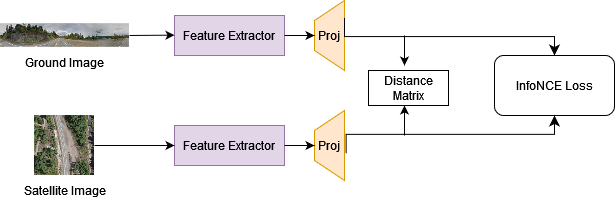![Dual Model.png](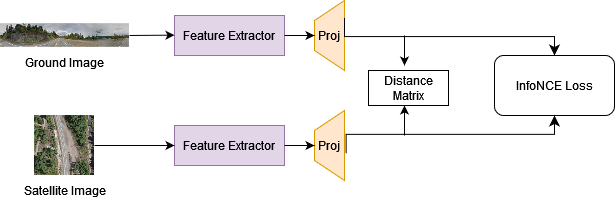![Dual Model.png](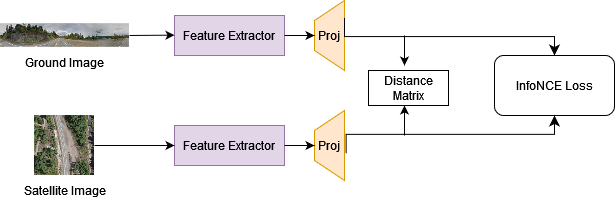![0043029.jpg](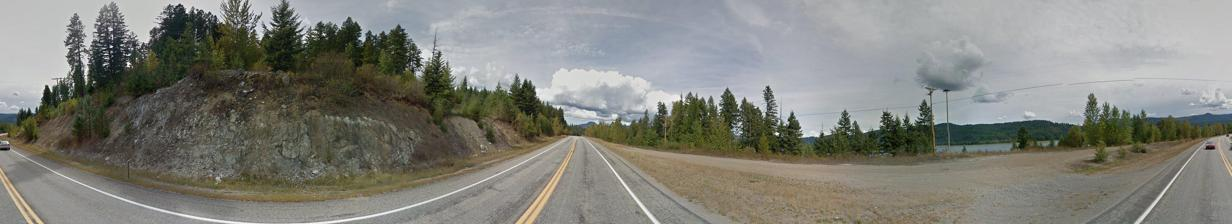![Dual Model.png](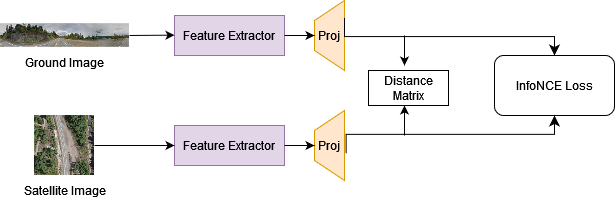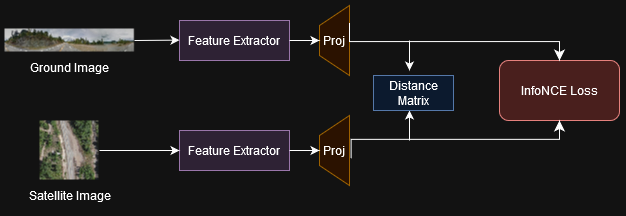))))).

In [9]:
#@title Implementation SoftMarginTripletLoss

class TripletLoss(pl.LightningModule):

    def __init__(self, loss_weight = 1.0):
        super().__init__()
        self.loss_weight = loss_weight


    def forward(self, image_features1, image_features2):
        image_features1 = F.normalize(image_features1, dim=-1)
        image_features2 = F.normalize(image_features2, dim=-1)
        dist_array = 2.0 - 2.0 * torch.matmul(image_features2, image_features1.T)
        n = len(image_features1)
        pos_dist = torch.diag(dist_array)
        pair_n = n * (n - 1.0)
        triplet_dist_g2s = pos_dist - dist_array
        loss_g2s = torch.sum(torch.log(1.0 + torch.exp(triplet_dist_g2s * self.loss_weight)))/pair_n
        triplet_dist_s2g = torch.unsqueeze(pos_dist, 1) - dist_array
        loss_s2g = torch.sum(torch.log(1.0 + torch.exp(triplet_dist_s2g * self.loss_weight)))/pair_n
        loss = (loss_g2s + loss_s2g) / 2.0

        return loss

In [10]:
#@title Implementation  InfoNCE Loss
class InfoNCE(pl.LightningModule):

    def __init__(self, loss_function, logit_scale=3.0):
        super().__init__()

        self.loss_function = loss_function #we can use a generic loss function!
        self.logit_scale = logit_scale


    def forward(self, image_features1, image_features2):

        image_features1 = F.normalize(image_features1, dim=-1)
        image_features2 = F.normalize(image_features2, dim=-1)

        # use pairwise_cosine_similarity instead? it's the same?
        logits_per_image1 = self.logit_scale * image_features1 @ image_features2.T
        logits_per_image2 = logits_per_image1.T

        labels = torch.arange(len(logits_per_image1), dtype=torch.long, device = device)
        loss = (self.loss_function(logits_per_image1, labels) + self.loss_function(logits_per_image2, labels))/2

        return loss

In [11]:
# @title Top-K Rank Accuracy: takes embeddings in input

def top_k_rank_accuracy(emb1, emb2, k=1):

    num_samples = len(emb1)

    if k > num_samples :
      return 0.0 # might happen at the end of the dataset (batch less then the chosen one)

    # replace with pairwise_cosine?
    emb1 = F.normalize(emb1, dim=-1)
    emb2 = F.normalize(emb2, dim=-1)
    dist_matrix = 1 - (emb1 @ emb2.T)

    _, topk_indices = torch.topk(dist_matrix, k = k, dim = 1, largest = False)

    correct_in_topk = sum([i in topk_indices[i, :] for i in range(num_samples)])

    accuracy = correct_in_topk / num_samples
    return accuracy

In [12]:
#@title Implementation of Attention operator
class Attention(pl.LightningModule):

    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)


    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [13]:
# @title Implementation ModelCheckpoint
class MyModelCheckpoint(ModelCheckpoint):
    def __init__(self, config, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.config = config

    def on_train_start(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        if not self.dirpath:
            raise ValueError("dirpath must be specified in ModelCheckpoint")
        file_path = os.path.join(os.path.dirname(self.dirpath), "config.txt")
        with open(file_path, 'w') as f:
            f.write(self.config)
            f.write('\n')

        return super().on_train_start(trainer, pl_module)

# Branches

In this section, we defined the backbone models that will be employed in the creation of our models.

We implemented:

1. **VGG16**: a well-known Convolutional Neural Network (CNN) that was introduced by the Visual Geometry Group (VGG) at the University of Oxford. It is known for its simplicity and depth, consisting of 16 layers with a fixed architecture using small convolution filters (3x3) throughout the network. VGG16 is widely used for image classification tasks and serves as a strong baseline model due to its straightforward design and effectiveness.

2. **ResNet**: ResNet addresses the vanishing gradient problem by using residual blocks, which allow the model to learn residual functions with reference to the layer inputs, rather than learning unreferenced functions.
We worked with 50, 101 and 152 versions.

3. **SAIG**: SAIG model integrates self-attention mechanisms into CNNs to capture long-range dependencies and contextual information more effectively than traditional convolutional operations alone. This approach combines the strengths of CNNs in extracting local features with the ability of self-attention to model global relationships within the data, making it suitable for tasks requiring a high level of detail and contextual understanding.

In [14]:
#@title VGG16

class VGG_net(pl.LightningModule):

    def __init__(self, img_size, architecture, num_max_pooling, in_channels=3, output_dim=1000):
        super(VGG_net, self).__init__()
        self.img_size = img_size
        self.architecture = architecture
        self.num_max_pooling = num_max_pooling
        self.in_channels = in_channels
        self.output_dim = output_dim
        self.division = 2 ** num_max_pooling

        self.conv_layers = self.create_conv_layers(architecture)

        self.fcs = nn.Sequential(
            nn.Linear(128 * img_size[0]//self.division * img_size[1]//self.division, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, output_dim),
        )


    def forward(self, x, featuremaps=False):
        for layer in self.conv_layers:
            x = layer(x)

            if featuremaps and x.shape[2]*x.shape[1] == 48*48:
                return x

        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x


    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(in_channels, out_channels, 3, 1, 1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                ]
                in_channels = x
            elif x == "M":
                layers += [nn.MaxPool2d(2, 2)]

        return nn.ModuleList(layers)

    def __repr__(self):
        return f"VGG_net(img_size={self.img_size}, architecture={self.architecture}, num_max_pooling={self.num_max_pooling}, in_channels={self.in_channels}, output_dim={self.output_dim})"

In [15]:
# @title Resnet

class ResNetBranch(pl.LightningModule):
    def __init__(self, output_dim, resnet_version=50):
        super(ResNetBranch, self).__init__()
        self.output_dim = output_dim
        self.resnet_version = resnet_version

        if resnet_version == 50:
            self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        elif resnet_version == 101:
            self.resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        elif resnet_version == 152:
            self.resnet = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        else:
            raise ValueError("Unsupported ResNet version. Choose from 50, 101, or 152.")

        # Modify the last layer for the specific task
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, self.output_dim)

    def forward(self, x, featuremaps=False):
        # To print the featuremap we need to return the last conv layer output
        if featuremaps:
            for name, layer in list(self.resnet.named_children())[:-2]:
                x = layer(x)
                if x.shape[2]*x.shape[1]<48*48: #magic number: dimension 16 for visualization
                  break
            return x
        else:
            return self.resnet(x)

    def __repr__(self):
        return f"ResNetBranch(output_dim={self.output_dim}, resnet_version={self.resnet_version})"

In [16]:
#@title SAIG


class ConvBnReluBlock(pl.LightningModule):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBnReluBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

###

class Block(pl.LightningModule):

    def __init__(
        self,
        dim,
        num_heads,
        qkv_bias=False,
        qk_scale=None,
        drop=0.,
        attn_drop=0.,
        dropout=0.,
        norm_layer=nn.LayerNorm
    ):

        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop
        )
        # check what is droppath
        self.dropout = nn.Dropout(dropout) if dropout > 0. else nn.Identity()


    def forward(self, x):
        B, N, C = x.shape
        x = x + self.dropout(self.attn(self.norm1(x)))
        return x

###

class SAIGBranch(pl.LightningModule):

    def __init__(self, img_size, patch_size=16, in_channels=3, embed_dim=768, num_heads = 8, depth = 4, smd_dim = 8, qkv_bias = True, qk_scale = None, drop_rate=0., attn_drop_rate=0., norm_layer=None, flatten=True):
        super(SAIGBranch, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.smd_dim = smd_dim
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.drop_rate = drop_rate
        self.attn_drop_rate = attn_drop_rate
        self.norm_layer = norm_layer
        self.flatten = flatten

        #potremmo salvare i parametri, ha qualche senso?
        self.output_dim = embed_dim * smd_dim

        self.grid_size = (img_size[0] // patch_size, img_size[1] // patch_size)

        if img_size[0] % patch_size != 0 or img_size[1] % patch_size != 0:
          print("Warning: image size is not divisible for patch size")

        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

        self.conv_bn_relu_blocks = nn.Sequential(
            ConvBnReluBlock(in_channels = self.in_channels, out_channels = 64, stride = 2),
            ConvBnReluBlock(in_channels = 64, out_channels = 128, stride = 2),
            ConvBnReluBlock(in_channels = 128, out_channels = 128, stride = 1),
            ConvBnReluBlock(in_channels = 128, out_channels = 256, stride = 2),
            ConvBnReluBlock(in_channels = 256, out_channels = 256, stride = 1),
            ConvBnReluBlock(in_channels = 256, out_channels = 512, stride = 2),
        )
        self.patch_block = nn.Conv2d(in_channels = 512, out_channels = embed_dim, kernel_size=1, stride=1 ,padding=0)
        self.attn_blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate)
            for i in range(depth)])

        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
        #self.pos_embed = nn.Parameter(torch.zeros(1, embed_dim, self.num_patches))
        self.pos_drop = nn.Dropout(p=drop_rate)

        #self.GAP = nn.AdaptiveAvgPool1d(1)

        #self.logits = nn.Linear(in_features = embed_dim, out_features = 512)

        self.smd = nn.Sequential(
            nn.Linear(self.num_patches, self.num_patches*4),
            nn.GELU(),
            nn.Linear(self.num_patches*4, self.num_patches),
            nn.Linear(self.num_patches, smd_dim)
        )


    def forward(self, x, featuremaps = False):

      # extract patch embeddings
      x = self.conv_bn_relu_blocks(x)

      if featuremaps:
        return x

      x = self.patch_block(x)
      x = x.flatten(2).transpose(1,2)
      #x = self.norm(x) CHECK

      # add position embeddings
      x = x + self.pos_embed
      x = self.pos_drop(x)

      # pass through sequence of attention blocks
      for blk in self.attn_blocks:
          x = blk(x)

      x = self.norm(x)
      # x = self.GAP(x.transpose(-1, -2)).squeeze(2)
      # x = self.logits(x)

      # if featuremaps:
      #   return x.resize(x.shape[0], self.grid_size[0], self.grid_size[1], 384)

      # x: b x 88 x 384
      x = x.transpose(-1, -2)
      x = self.smd(x)
      x = x.transpose(-1, -2)
      x = x.flatten(-2, -1)

      return x

    def __repr__(self):
        return f"SAIGBranch(img_size={self.img_size}, patch_size={self.patch_size}, in_channels={self.in_channels}, embed_dim={self.embed_dim}, num_heads={self.num_heads}, depth={self.depth}, smd_dim={self.smd_dim}, qkv_bias={self.qkv_bias}, qk_scale={self.qk_scale}, drop_rate={self.drop_rate}, attn_drop_rate={self.attn_drop_rate}, norm_layer={self.norm_layer}, flatten={self.flatten})"

# Generic Model

In [ ]:
# generic model, some methods are left abstract and should be implemented following
# certain rules:

# the "forward" function takes the whole batch as input, it has to divide it,
# apply the branches and return 3 elements: a tuple with all the output of all
# the embeddings, the total ground embedding and the total satellite embedding

# the "compute_loss" function takes the tuple with all the embeddings and the
# two total embeddings as input, compute the loss and return it.

# the "__repr__" function returns a string representing the model

In [26]:
# @title Multi-Branch Model

class MultiBranchModel(pl.LightningModule):

    def __init__(self, loss):
        super(MultiBranchModel, self).__init__()

        self.loss = loss

        self.grd_features_train = []
        self.sat_features_train = []

        self.grd_features_val =  []
        self.sat_features_val =  []

        self.grd_features_test = []
        self.sat_features_test = []


    @abc.abstractmethod
    def forward(self, batch):
        return


    @abc.abstractmethod
    def compute_loss(self, embeddings, grd_emb, sat_emb):
        return


    def training_step(self, batch, batch_idx):
        embeddings, grd_emb, sat_emb = self(batch)

        loss = self.compute_loss(embeddings, grd_emb, sat_emb)
        top_1 = top_k_rank_accuracy(grd_emb, sat_emb, k=1)

        self.log('train_top1', top_1, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss


    def validation_step(self, batch, batch_idx):
        _, grd_emb, sat_emb = self(batch)

        self.grd_features_val.append(grd_emb)
        self.sat_features_val.append(sat_emb)


    def on_validation_epoch_end(self):

      grd_features_val = torch.cat(self.grd_features_val, dim=0)
      sat_features_val = torch.cat(self.sat_features_val, dim=0)

      num_samples = grd_features_val.shape[0]
      percent1 = int(0.01*num_samples)

      top_1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=1)
      top_3 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=3)
      top_10 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=10)
      top_percent1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=percent1)

      self.log('val_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

      self.grd_features_val.clear()
      self.sat_features_val.clear()
      del grd_features_val, sat_features_val

      return top_1, top_3, top_10, top_percent1


    def test_step(self, batch, batch_idx):
        _, grd_emb, sat_emb = self(batch)

        self.grd_features_test.append(grd_emb)
        self.sat_features_test.append(sat_emb)


    def on_test_epoch_end(self):

      grd_features_test = torch.cat(self.grd_features_test, dim = 0)
      sat_features_test = torch.cat(self.sat_features_test, dim = 0)

      num_samples = grd_features_test.shape[0]
      percent1 = int(0.01*num_samples)

      top_1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=1)
      top_3 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=3)
      top_10 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=10)
      top_percent1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=percent1)

      self.log('test_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

      self.grd_features_test.clear()
      self.sat_features_test.clear()
      del grd_features_test, sat_features_test

      return top_1, top_3, top_10, top_percent1


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


    @abc.abstractmethod
    def __repr__(self):
        return

In [27]:
# @title Dual Model

class DualModel(MultiBranchModel):

    def __init__(
        self,
        model_grd,
        model_sat,
        loss = InfoNCE(loss_function=nn.CrossEntropyLoss())
    ):
        super(DualModel, self).__init__(loss)

        # create branches
        self.branch1 = model_grd
        self.branch2 = model_sat

        # check output dimension
        if self.branch1.output_dim != self.branch2.output_dim:
          raise ValueError("Mismatching output dimensions for the branches!")
        self.output_dim = self.branch1.output_dim


    def forward(self, batch):
        # elaborate the batch
        grd_imgs, _, _, sat_imgs, _ = batch

        # apply the models
        grd_emb = self.branch1(grd_imgs['imgs'])
        sat_emb = self.branch2(sat_imgs['imgs'])

        return (grd_emb, sat_emb), grd_emb, sat_emb


    def compute_loss(self, embeddings, grd_emb, sat_emb):
        loss = self.loss(grd_emb, sat_emb)
        return loss


    def __repr__(self):
        return f"DualModel(model_grd={self.branch1}, model_sat={self.branch2}, loss={self.loss})"

In [ ]:
# @title Dual Model with all features

class DualModel_all(MultiBranchModel):

    def __init__(
        self,
        model_grd,
        model_sat,
        loss = InfoNCE(loss_function=nn.CrossEntropyLoss())
    ):
        super(DualModel_all, self).__init__()

        # create branches
        self.branch1 = model_grd
        self.branch2 = model_sat

        # check output dimension
        if self.branch1.output_dim != self.branch2.output_dim:
          raise ValueError("Mismatching output dimensions for the branches!")
        self.output_dim = self.branch1.output_dim


    def forward(self, batch):
        # elaborate the batch
        grd_img, grd_seg, grd_depth, sat_img, sat_seg = branch
        grd_tot = torch.cat((grd_img['imgs'], grd_seg['imgs'], grd_depth['imgs']), dim = 1)
        sat_tot = torch.cat((sat_img['imgs'], sat_seg['imgs']), dim = 1)

        # apply the models
        grd_emb = self.branch1(grd_tot)
        sat_emb = self.branch4(sat_tot)

        return (grd_emb, sat_emb), grd_emb, sat_emb


    def compute_loss(self, embeddings, grd_emb, sat_emb):
        loss = self.loss(grd_emb, sat_emb)
        return loss


    def __repr__(self):
        return f"DualModel(model_grd={self.branch1}, model_sat={self.branch2}, loss={self.loss})"

In [ ]:
#@title Triple Model satellite using multiple losses

class TripleModel_sat(MultiBranchModel):

    def __init__(
        self,
        model_grd,
        model_sat,
        model_sat_seg,
        loss=InfoNCE(loss_function=nn.CrossEntropyLoss()),
        fully_concat=True,
        multiple_losses=True
    ):
        super(TripleModel_sat, self).__init__()

        # create branches
        self.branch1 = model_grd
        self.branch2 = model_sat
        self.branch3 = model_sat_seg

        # check output dimension
        if self.branch1.output_dim != (self.branch2.output_dim + self.branch3.output_dim):
            raise ValueError("Mismatching output dimensions for the branches!")
        self.output_dim = self.branch1.output_dim

        self.fully_concat = fully_concat
        self.multiple_losses = multiple_losses

        # To make concatenation learnable
        if fully_concat:
            self.fc = nn.Linear(self.output_dim, self.output_dim)


    def forward(self, batch):
        # elaborate the batch
        grd_imgs, _, _, sat_imgs, sat_seg = batch

        # apply the models
        grd_emb = self.branch1(grd_imgs['imgs'])
        sat_rgb_emb = self.branch2(sat_imgs['imgs'])
        sat_seg_emb = self.branch3(sat_seg['imgs'])

        # compute the total embeddings
        sat_emb = torch.cat((sat_rgb_emb, sat_seg_emb), dim=1)
        if self.fully_concat:
            sat_emb = self.fc(sat_emb)

        return (grd_emb, sat_rgb_emb, sat_seg_emb), grd_emb, sat_emb


    def compute_loss(self, embeddings, grd_emb, sat_emb):
        loss = self.loss(grd_emb, sat_emb)
        if self.multiple_losses:
            loss += self.loss(embeddings[1], embeddings[2])

        return loss


    def __repr__(self):
        return f"""TripleModel_sat(model_grd={self.branch1}, model_sat={self.branch2},
        model_sat_seg={self.branch3}, loss={self.loss}, fully_concat={self.fully_concat},
        use_multiple_losses={self.use_multiple_losses})"""

In [ ]:
# @title Quadruple Model

class QuadrupleModel(MultiBranchModel):
    def __init__(
        self,
        model_grd,
        model_grd_seg,
        model_sat,
        model_sat_seg,
        loss=InfoNCE(loss_function=nn.CrossEntropyLoss()),
        multiple_losses=True,
        fully_concat=True
    ):
        super(QuadrupleModel, self).__init__()

        # create branches
        self.branch1 = model_grd
        self.branch2 = model_grd_seg
        self.branch3 = model_sat
        self.branch4 = model_sat_seg

        # check output dimension
        if self.branch1.output_dim + self.branch2.output_dim != self.branch3.output_dim + self.branch4.output_dim:
          raise ValueError("Mismatching output dimensions for the branches!")
        self.output_dim = self.branch1.output_dim + self.branch2.output_dim

        self.fully_concat = fully_concat
        self.multiple_losses = multiple_losses

        # To make concatenations learnable
        if fully_concat:
          self.fc_grd = nn.Linear(self.output_dim, self.output_dim)
          self.fc_sat = nn.Linear(self.output_dim, self.output_dim)


    def forward(self, batch):
        # elaborate the batch
        grd_img, grd_seg, _, sat_img, sat_seg = batch

        # apply the models
        grd_rgb_emb = self.branch1(grd_img['imgs'])
        grd_seg_emb = self.branch2(grd_seg_img['imgs'])
        sat_rgb_emb = self.branch3(sat_img['imgs'])
        sat_seg_emb = self.branch4(sat_seg_img['imgs'])

        # compute the total embeddings
        grd_emb = torch.cat((grd_rgb_emb, grd_seg_emb), dim=1)
        sat_emb = torch.cat((sat_rgb_emb, sat_seg_emb), dim=1)
        if self.fully_concat:
          grd_emb = self.fc_grd(grd_emb)
          sat_emb = self.fc_sat(sat_emb)

        return (grd_rgb_emb, grd_seg_emb, sat_rgb_emb, sat_seg_emb), grd_emb, sat_emb


    def compute_loss(self, embeddings, grd_emb, sat_emb):
        loss = self.loss(grd_emb, sat_emb)
        if self.multiple_losses:
            loss += self.loss(embeddings[0], embeddings[1])
            loss += self.loss(embeddings[2], embeddings[3])

        return loss


    def __repr__(self):
        return f"""QuadrupleModel(model_grd={self.branch1}, model_grd_seg={self.branch2},
        model_sat={self.branch3}, model_sat_seg={self.branch4}, loss={self.loss},
        multiple_losses={self.multiple_losses}, fully_concat_grd={self.fully_concat_grd},
        fully_concat_sat={self.fully_concat_sat})"""

In [ ]:
# @title Quintuple Model

class QuintupleModel(pl.MultiBranchModel):
    def __init__(
        self,
        model_grd,
        model_grd_seg,
        model_grd_depth,
        model_sat,
        model_sat_seg,
        loss=InfoNCE(loss_function=nn.CrossEntropyLoss()),
        multiple_losses=True,
        fully_concat=True
    ):
        super(QuintupleModel, self).__init__()

        # create branches
        self.branch1 = model_grd
        self.branch2 = model_grd_seg
        self.branch3 = model_grd_depth
        self.branch4 = model_sat
        self.branch5 = model_sat_seg

        # check output dimension
        if self.branch1.output_dim + self.branch2.output_dim + self.branch3.output_dim != self.branch4.output_dim + self.branch5.output_dim:
          raise ValueError("Mismatching output dimensions for the branches!")
        self.output_dim = self.branch1.output_dim + self.branch2.output_dim + self.branch3.output_dim

        self.fully_concat = fully_concat
        self.multiple_losses = multiple_losses

        # To make concatenations learnable
        if fully_concat:
          self.fc_grd = nn.Linear(self.output_dim, self.output_dim)
          self.fc_sat = nn.Linear(self.output_dim, self.output_dim)


    def forward(self, x):
        # elaborate the batch
        grd_img, grd_seg, grd_depth, sat_img, sat_seg = branch

        # apply the models
        grd_rgb_emb = self.branch1(grd_img['imgs'])
        grd_seg_emb = self.branch2(grd_seg['imgs'])
        grd_dep_emb = self.branch3(grd_depth['imgs'])
        sat_rgb_emb = self.branch4(sat_img['imgs'])
        sat_seg_emb = self.branch5(sat_seg['imgs'])

        # compute the total embeddings
        grd_emb = torch.cat((grd_rgb_emb, grd_seg_emb, grd_dep_emb), dim=1)
        sat_emb = torch.cat((sat_rgb_emb, sat_seg_emb), dim=1)
        if self.fully_concat:
          grd_emb = self.fc_grd(grd_emb)
          sat_emb = self.fc_sat(sat_emb)

        return (grd_rgb_emb, grd_seg_emb, grd_dep_emb, sat_rgb_emb, sat_seg_emb)


    def compute_loss(self, embeddings, grd_emb, sat_emb):
        loss = self.loss(grd_emb, sat_emb)
        if self.multiple_losses:
            loss += self.loss(embeddings[0], embeddings[1])
            loss += self.loss(embeddings[0], embeddings[2])
            loss += self.loss(embeddings[1], embeddings[2])
            loss += self.loss(embeddings[3], embeddings[4])

        return loss


    def __repr__(self):
        return f"""QuintupleModel(model_grd={self.branch1}, model_grd_seg={self.branch2},
        model_grd_depth={self.branch3}, model_sat={self.branch4}, model_sat_seg={self.branch5},
        loss={self.loss}, multiple_losses={self.multiple_losses},
        fully_concat_grd={self.fully_concat_grd}, fully_concat_sat={self.fully_concat_sat})"""

# Dual Model (RGB Grd | RGB Sat)

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1GiA7Bi3xAkRg5j_NiimIqaVc4v5XujXZ' />
<figcaption>Dual Model architecture</figcaption></center>
</figure>

The architecture is proposed as the baseline model. It uses two branches to extract features of the ground and of the satellite images, and projects them into a latent space, describing them as vectors.

To match the correct images, we compute the distances between the descriptors of the satellite images and the vectors of the ground images. Specifically, we create a distance matrix where each element represents the distance between a descriptor from a satellite image and a vector from a ground image. By calculating these distances, we can identify pairs of satellite and ground images that are closest to each other in the latent space, thereby matching the images accurately.

In [ ]:
# @title Dual Model

class DualModel(pl.LightningModule):

    def __init__(self, model_grd, model_sat, loss = InfoNCE(loss_function=nn.CrossEntropyLoss())):
        super(DualModel, self).__init__()
        self.branch1 = model_grd
        self.branch2 = model_sat

        if self.branch1.output_dim != self.branch2.output_dim:
          raise ValueError("ATTENTION, MISMATCHING OUTPUT DIMENSIONS FOR THE BRANCHES!")

        self.output_dim = self.branch1.output_dim

        self.loss = loss

        #train
        #self.grd_features_train =torch.empty((0, self.output_dim), device = device)
        #self.sat_features_train =torch.empty((0, self.output_dim), device = device)

        #validation
        self.grd_features_val =  []
        self.sat_features_val =  []
        #test
        self.grd_features_test = []
        self.sat_features_test = []


    def forward(self, x1, x2):
        out1 = self.branch1(x1['imgs'])
        out2 = self.branch2(x2['imgs'])
        return out1, out2


    def training_step(self, batch, batch_idx):
        grd_img, _, _, sat_img, _ = batch
        out1, out2 = self(grd_img, sat_img)

        loss = self.loss(out1, out2)

        top_1 = top_k_rank_accuracy(out1, out2, k=1)

        self.log('train_top1', top_1, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss


    def validation_step(self, batch, batch_idx):
        grd_img, _, _, sat_img, _ = batch
        out1, out2 = self(grd_img, sat_img)

        self.grd_features_val.append(out1)
        self.sat_features_val.append(out2)


    def on_validation_epoch_end(self):

      grd_features_val = torch.cat(self.grd_features_val, dim=0)
      sat_features_val = torch.cat(self.sat_features_val, dim=0)

      num_samples = grd_features_val.shape[0]
      percent1 = int(0.01*num_samples)

      top_1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=1)
      top_3 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=3)
      top_10 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=10)
      top_percent1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=percent1)

      self.log('val_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

      #we deallocate the memory!

      #validation
      self.grd_features_val.clear()
      self.sat_features_val.clear()

      del grd_features_val, sat_features_val

      return top_1, top_3, top_10, top_percent1


    def test_step(self, batch, batch_idx):
        grd_img, _, _, sat_img, _ = batch
        out1, out2 = self(grd_img, sat_img)

        self.grd_features_test.append(out1)
        self.sat_features_test.append(out2)


    def on_test_epoch_end(self):

      grd_features_test = torch.cat(self.grd_features_test, dim = 0)
      sat_features_test = torch.cat(self.sat_features_test, dim = 0)

      num_samples = grd_features_test.shape[0]
      percent1 = int(0.01*num_samples)

      top_1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=1)
      top_3 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=3)
      top_10 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=10)
      top_percent1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=percent1)

      self.log('test_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

      #we deallocate the memory!

      self.grd_features_test.clear()
      self.sat_features_test.clear()

      del grd_features_test, sat_features_test

      return top_1, top_3, top_10, top_percent1


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def __repr__(self):
        return f"DualModel(model_grd={self.branch1}, model_sat={self.branch2}, loss={self.loss})"

In [28]:
#@title Create Model

branch_type = 'saig'

###

if branch_type == 'resnet':

    grd_model = ResNetBranch(output_dim=128, resnet_version = 50)
    sat_model = ResNetBranch(output_dim = 128,  resnet_version = 50)


elif branch_type == 'saig':

    grd_model = SAIGBranch(
        data_module.size['grd'],
        embed_dim= 256,
        num_heads = 4,
        depth = 4,
        smd_dim = 8
    )

    sat_model = SAIGBranch(
        data_module.size['sat'],
        embed_dim= 256,
        num_heads = 4,
        depth = 4,
        smd_dim = 8
    )


elif branch_type == 'vgg':

    # Output channel of each layer in the convolution layers
    # "M" stands for maxpooling layer
    #VGG16 = [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"]
    #VGG16 = [32, 32, "M", 64, 64, "M", 128, 128, 128, "M", 256, 256, 256, "M", 256, 256, 256, "M"]
    VGG16 = [16, 16, "M", 32, 32, "M", 64, 64, 64, "M", 128, 128, 128, "M", 128, 128, 128, "M"]

    grd_model = VGG_net(data_module.size['grd'], VGG16, VGG16.count("M"), output_dim = 100)
    sat_model = VGG_net(data_module.size['sat'], VGG16, VGG16.count("M"), output_dim = 100)
else:

  raise ValueError("Should specify some model between the chosable ones")

###

model = DualModel(grd_model, sat_model)

In [29]:
# @title Create Trainer

logger = TensorBoardLogger("tb_logs", name="dual_model")
checkpoint_callback = MyModelCheckpoint(
    filename='dual_model-{epoch}-{val_top1:.2f}',
    mode="max",
    every_n_epochs=1,
    save_top_k=1,
    config=repr(model)
)

trainer = pl.Trainer(
    logger=logger,
    max_epochs = 30,
    devices = 1,
    callbacks = [RichProgressBar(), EarlyStopping(monitor="val_top1", patience=3, mode="max"), checkpoint_callback],
    log_every_n_steps = 3,
    default_root_dir = "/content/"
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [30]:
# @title Train

trainer.fit(
    model = model,
    train_dataloaders = train_loader,
    val_dataloaders = val_loader,
    ckpt_path="last"
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:186: .fit(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded. HINT: Set `ModelCheckpoint(..., save_last=True)`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss    │ InfoNCE    │      0 │
│ 1 │ branch1 │ SAIGBranch │  4.6 M │
│ 2 │ branch2 │ SAIGBranch │  3.5 M │
└───┴─────────┴────────────┴────────┘

Trainable params: 8.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.1 M                                                                                                
Total estimated model params size (MB): 32

Output()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a 
cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: 
CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, 
attempting graceful shutdown...

In [ ]:
# @title Test

trainer.test(
    model = model,
    dataloaders = val_loader
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

# Dual Model (ALL Grd | ALL Sat)

In [ ]:
# @title Dual Model with all features

class DualModel_all(pl.LightningModule):

    def __init__(self, model_grd, model_sat, loss = InfoNCE(loss_function=nn.CrossEntropyLoss())):
        super(DualModel_all, self).__init__()
        self.branch1 = model_grd
        self.branch2 = model_sat

        if self.branch1.output_dim != self.branch2.output_dim:
          raise ValueError("ATTENTION, MISMATCHING OUTPUT DIMENSIONS FOR THE BRANCHES!")

        self.output_dim = self.branch1.output_dim

        self.loss = loss

        #train
        #self.grd_features_train =torch.empty((0, self.output_dim), device = device)
        #self.sat_features_train =torch.empty((0, self.output_dim), device = device)

        #validation
        self.grd_features_val =  []
        self.sat_features_val =  []
        #test
        self.grd_features_test = []
        self.sat_features_test = []


    def forward(self, batch):

        x1 = torch.cat((batch[0]['imgs'], batch[1]['imgs'], batch[2]['imgs']), dim = 1)
        x2 = torch.cat((batch[3]['imgs'], batch[4]['imgs']), dim = 1)
        out1 = self.branch1(x1)
        out2 = self.branch2(x2)

        return out1, out2


    def training_step(self, batch, batch_idx):
        out1, out2 = self(batch)

        loss = self.loss(out1, out2)

        top_1 = top_k_rank_accuracy(out1, out2, k=1)

        self.log('train_top1', top_1, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss


    def validation_step(self, batch, batch_idx):
        out1, out2 = self(batch)

        self.grd_features_val.append(out1)
        self.sat_features_val.append(out2)


    def on_validation_epoch_end(self):

      grd_features_val = torch.cat(self.grd_features_val, dim=0)
      sat_features_val = torch.cat(self.sat_features_val, dim=0)

      num_samples = grd_features_val.shape[0]
      percent1 = int(0.01*num_samples)

      top_1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=1)
      top_3 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=3)
      top_10 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=10)
      top_percent1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=percent1)

      self.log('val_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

      #we deallocate the memory!

      #validation
      self.grd_features_val.clear()
      self.sat_features_val.clear()

      del grd_features_val, sat_features_val

      return top_1, top_3, top_10, top_percent1


    def test_step(self, batch, batch_idx):
        out1, out2 = self(batch)

        self.grd_features_test.append(out1)
        self.sat_features_test.append(out2)


    def on_test_epoch_end(self):

      grd_features_test = torch.cat(self.grd_features_test, dim = 0)
      sat_features_test = torch.cat(self.sat_features_test, dim = 0)

      num_samples = grd_features_test.shape[0]
      percent1 = int(0.01*num_samples)

      top_1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=1)
      top_3 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=3)
      top_10 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=10)
      top_percent1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=percent1)

      self.log('test_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

      #we deallocate the memory!

      self.grd_features_test.clear()
      self.sat_features_test.clear()

      del grd_features_test, sat_features_test

      return top_1, top_3, top_10, top_percent1


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def __repr__(self):
        return f"DualModel(model_grd={self.branch1}, model_sat={self.branch2}, loss={self.loss})"

In [ ]:
#@title Create Model

branch_type = 'saig'

###

if branch_type == 'resnet':

    grd_model = ResNetBranch(output_dim=128, resnet_version = 50)
    sat_model = ResNetBranch(output_dim = 128,  resnet_version = 50)


elif branch_type == 'saig':

    grd_model = SAIGBranch(
        data_module.size['grd'],
        embed_dim= 256,
        num_heads = 4,
        depth = 4,
        smd_dim = 8,
        in_channels = 9
    )

    sat_model = SAIGBranch(
        data_module.size['sat'],
        embed_dim= 256,
        num_heads = 4,
        depth = 4,
        smd_dim = 8,
        in_channels = 6
    )


elif branch_type == 'vgg':

    # Output channel of each layer in the convolution layers
    # "M" stands for maxpooling layer
    #VGG16 = [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"]
    #VGG16 = [32, 32, "M", 64, 64, "M", 128, 128, 128, "M", 256, 256, 256, "M", 256, 256, 256, "M"]
    VGG16 = [16, 16, "M", 32, 32, "M", 64, 64, 64, "M", 128, 128, 128, "M", 128, 128, 128, "M"]

    grd_model = VGG_net(data_module.size['grd'], VGG16, VGG16.count("M"), output_dim = 100)
    sat_model = VGG_net(data_module.size['sat'], VGG16, VGG16.count("M"), output_dim = 100)


else:

  raise ValueError("Should specify some model between the chosable ones")


###

model = DualModel_all(grd_model, sat_model)

In [ ]:
# @title Create Trainer

logger = TensorBoardLogger("tb_logs", name="dual_model")
checkpoint_callback = MyModelCheckpoint(
    filename='dual_model-{epoch}-{val_top1:.2f}',
    mode="max",
    every_n_epochs=1,
    save_top_k=1,
    config=repr(model)
)

trainer = pl.Trainer(
    logger=logger,
    max_epochs = 30,
    devices = 1,
    callbacks = [RichProgressBar(), EarlyStopping(monitor="val_top1", patience=3, mode="max"), checkpoint_callback],
    log_every_n_steps = 3,
    default_root_dir = "/content/"
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# @title Train

trainer.fit(
    model = model,
    train_dataloaders = train_loader,
    val_dataloaders = val_loader,
    ckpt_path="last"
)

Epoch 9/29 ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156/831 0:01:29 • 0:06:37 1.70it/s v_num: 6.000 train_top1_step:     
                                                                                 0.250 train_loss_step: 1.676      
                                                                                 val_top1: 0.003 val_top3: 0.010   
                                                                                 val_top10: 0.036 val_top1%: 0.077 
                                                                                 train_top1_epoch: 0.409           
                                                                                 train_loss_epoch: 1.598           

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, 
attempting graceful shutdown...

In [ ]:
# @title Test

trainer.test(
    model = model,
    dataloaders = val_loader
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

# Triple Model (RGB Grd | RGB + SEG Sat) and (RGB Sat | RGB + SEG Grd)

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=17ql5CPDt4zYVDweuADsO5brW-ikqGzXK' />
<figcaption>Triple Model architecture using satellite segmentation</figcaption></center>
</figure>

The architecture is proposed as a slight modification of the architecture used in the original paper. It uses three branches to extract features of the ground, satellite images and satellite segmentation images, and projects them into a latent space, describing them as vectors.

Differently from the Dual Model, me first concatenate (using also a fully connected layer to make differentiable such operation) the embeddings of the two satellite images, then as for the dual model we evaluate the distance matrix over such vectors.

Another difference from the previous model is the possibility of defining an auxilary loss that works on the embeddings produced by the two sub-branches related to satellite images. By minimizing such a loss the idea is that the model is able to learn a good representation of such embeddings in a more direct way making them less dependent on layers of the network that appear later. During our tentatives, the models using such auxilary losses exhibited better performances in early epoches.

In [ ]:
#@title Triple Model satellite using multiple losses
class TripleModel_sat(pl.LightningModule):

    def __init__(self, model_grd, model_sat, model_sat_seg, loss=InfoNCE(loss_function=nn.CrossEntropyLoss()), fully_concat=True, multiple_losses=True):
        super(TripleModel_sat, self).__init__()
        self.branch1 = model_grd
        self.branch2 = model_sat
        self.branch3 = model_sat_seg

        # Verify that grd output dim is coherent with the sum of the other two models
        if self.branch1.output_dim != (self.branch2.output_dim + self.branch3.output_dim):
            raise ValueError("ATTENTION, MISMATCHING OUTPUT DIMENSIONS FOR THE BRANCHES! Must have output_dim1 = output_dim2 + output_dim3")

        self.output_dim = self.branch1.output_dim
        self.fully_concat = fully_concat
        self.multiple_losses = multiple_losses

        if fully_concat:  # To make concatenation learnable
            self.fc = nn.Linear(self.output_dim, self.output_dim)

        self.loss = loss

        # Validation
        self.grd_features_val = []
        self.sat_features_val = []  # IMPORTANT: SAT is BOTH SAT and SEG!!!! WE COMBINE THEM!

        # Test
        self.grd_features_test = []
        self.sat_features_test = []

    def forward(self, x1, x2, x3):
        out1 = self.branch1(x1['imgs'])
        out2 = self.branch2(x2['imgs'])
        out3 = self.branch3(x3['imgs'])
        combined_out2 = torch.cat((out2, out3), dim=1)  # Concatenation of features
        if self.fully_concat:
            combined_out2 = self.fc(combined_out2)
        return out1, combined_out2, out2, out3

    def training_step(self, batch, batch_idx):
        grd_img, _, _, sat_img, sat_seg_img = batch
        out1, combined_out2, out2, out3 = self(grd_img, sat_img, sat_seg_img)

        loss1 = self.loss(out1, combined_out2)
        total_loss = loss1

        if self.multiple_losses:
            loss2 = self.loss(out2, out3)
            total_loss += loss2

        top_1 = top_k_rank_accuracy(out1, combined_out2, k=1)

        self.log('train_top1', top_1, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_loss", total_loss, on_step=True, on_epoch=True, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        grd_img, _, _, sat_img, sat_seg_img = batch
        out1, combined_out2, _, _ = self(grd_img, sat_img, sat_seg_img)

        self.grd_features_val.append(out1)
        self.sat_features_val.append(combined_out2)

    def on_validation_epoch_end(self):
        grd_features_val = torch.cat(self.grd_features_val, dim=0)
        sat_features_val = torch.cat(self.sat_features_val, dim=0)

        num_samples = grd_features_val.shape[0]
        percent1 = int(0.01 * num_samples)

        top_1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=1)
        top_3 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=3)
        top_10 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=10)
        top_percent1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=percent1)

        self.log('val_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

        # We deallocate the memory!
        self.grd_features_val.clear()
        self.sat_features_val.clear()

        del grd_features_val, sat_features_val

        return top_1, top_3, top_10, top_percent1

    def test_step(self, batch, batch_idx):
        grd_img, _, _, sat_img, sat_seg_img = batch
        out1, combined_out2, _, _ = self(grd_img, sat_img, sat_seg_img)

        self.grd_features_test.append(out1)
        self.sat_features_test.append(combined_out2)

    def on_test_epoch_end(self):
        grd_features_test = torch.cat(self.grd_features_test, dim=0)
        sat_features_test = torch.cat(self.sat_features_test, dim=0)

        num_samples = grd_features_test.shape[0]
        percent1 = int(0.01 * num_samples)

        top_1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=1)
        top_3 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=3)
        top_10 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=10)
        top_percent1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=percent1)

        self.log('test_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

        # We deallocate the memory!
        self.grd_features_test.clear()
        self.sat_features_test.clear()

        del grd_features_test, sat_features_test

        return top_1, top_3, top_10, top_percent1

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def __repr__(self):
        return f"TripleModel_sat(model_grd={self.branch1}, model_sat={self.branch2}, model_sat_seg={self.branch3}, loss={self.loss}, fully_concat={self.fully_concat}, use_multiple_losses={self.use_multiple_losses})"

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1bEYjAd5i-B5YQ1GHsbDkZ12a0dYx28--' />
<figcaption>Triple Model architecture using ground segmentation</figcaption></center>
</figure>

An alternative approach with the triple model was tried. The proposed alternative architecture uses three branches to extract features of the ground, ground segmentation images, satellite images, and projects them into a latent space, describing them as vectors.

Like the previous model, we concatenate the embeddings to then compare the vectors describing the input images to match the right images.

Even in this case, we tried to employ an auxilary loss (in this case defined on the embeddings resulting from the ground sub-branches).

In [ ]:
#@title Triple Model ground with multiple losses
class TripleModel_grd(pl.LightningModule):

    def __init__(self, model_grd, model_sat, model_grd_seg, loss=InfoNCE(loss_function=nn.CrossEntropyLoss()), fully_concat=True, multiple_losses=True):
        super(TripleModel_grd, self).__init__()
        self.branch1 = model_grd
        self.branch2 = model_grd_seg
        self.branch3 = model_sat

        # Verify that grd output dim is coherent with the sum of the other two models
        if self.branch3.output_dim != (self.branch2.output_dim + self.branch1.output_dim):
            raise ValueError("ATTENTION, MISMATCHING OUTPUT DIMENSIONS FOR THE BRANCHES! Must have output_dim1 = output_dim2 + output_dim3")

        self.output_dim = self.branch3.output_dim
        self.fully_concat = fully_concat
        self.multiple_losses = multiple_losses

        if fully_concat:  # to make concatenation learnable
            self.fc = nn.Linear(self.output_dim, self.output_dim)

        self.loss = loss

        # Validation
        self.grd_features_val = []
        self.sat_features_val = []  # IMPORTANT: SAT is BOTH SAT and SEG!!!! WE COMBINE THEM!

        # Test
        self.grd_features_test = []
        self.sat_features_test = []

    def forward(self, x1, x2, x3):
        out1 = self.branch1(x1['imgs'])
        out2 = self.branch2(x2['imgs'])
        out3 = self.branch3(x3['imgs'])
        combined_out1 = torch.cat((out1, out2), dim=1)  # concatenation of features
        if self.fully_concat:
            combined_out1 = self.fc(combined_out1)
        return combined_out1, out3, out1, out2

    def training_step(self, batch, batch_idx):
        grd_img, grd_seg_img, _, sat_img, _ = batch
        combined_out1, out3, out1, out2 = self(grd_img, grd_seg_img, sat_img)

        loss1 = self.loss(combined_out1, out3)
        total_loss = loss1

        if self.multiple_losses:
            loss2 = self.loss(out1, out2)
            total_loss += loss2

        top_1 = top_k_rank_accuracy(combined_out1, out3, k=1)

        self.log('train_top1', top_1, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_loss", total_loss, on_step=True, on_epoch=True, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        grd_img, grd_seg_img, _, sat_img, _ = batch
        combined_out1, out3, _, _ = self(grd_img, grd_seg_img, sat_img)

        self.grd_features_val.append(combined_out1)
        self.sat_features_val.append(out3)

    def on_validation_epoch_end(self):
        grd_features_val = torch.cat(self.grd_features_val, dim=0)
        sat_features_val = torch.cat(self.sat_features_val, dim=0)

        num_samples = grd_features_val.shape[0]
        percent1 = int(0.01 * num_samples)

        top_1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=1)
        top_3 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=3)
        top_10 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=10)
        top_percent1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=percent1)

        self.log('val_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

        # We deallocate the memory!
        self.grd_features_val.clear()
        self.sat_features_val.clear()

        del grd_features_val, sat_features_val

        return top_1, top_3, top_10, top_percent1

    def test_step(self, batch, batch_idx):
        grd_img, grd_seg_img, _, sat_img, _ = batch
        combined_out1, out3, _, _ = self(grd_img, grd_seg_img, sat_img)

        self.grd_features_test.append(combined_out1)
        self.sat_features_test.append(out3)

    def on_test_epoch_end(self):
        grd_features_test = torch.cat(self.grd_features_test, dim=0)
        sat_features_test = torch.cat(self.sat_features_test, dim=0)

        num_samples = grd_features_test.shape[0]
        percent1 = int(0.01 * num_samples)

        top_1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=1)
        top_3 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=3)
        top_10 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=10)
        top_percent1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=percent1)

        self.log('test_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

        # We deallocate the memory!
        self.grd_features_test.clear()
        self.sat_features_test.clear()

        del grd_features_test, sat_features_test

        return top_1, top_3, top_10, top_percent1

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def __repr__(self):
        return f"TripleModel_grd(model_grd={self.branch1}, model_sat={self.branch2}, model_grd_seg={self.branch3}, loss={self.loss}, fully_concat={self.fully_concat}, use_multiple_losses={self.use_multiple_losses})"

In [ ]:
# @title Create Model
grd_model = ResNetBranch(output_dim = 512, resnet_version = 50) #LOOKS PROMISING!!!
sat_model = ResNetBranch(output_dim = 256,  resnet_version = 50)
seg_model = ResNetBranch(output_dim = 256,  resnet_version = 50)

"""grd_model = SAIGBranch(
        data_module.size['grd'],
        embed_dim= 384,
        num_heads = 8,
        depth = 4,
        smd_dim = 12
    )

sat_model = SAIGBranch(
        data_module.size['sat'],
        embed_dim= 384,
        num_heads = 8,
        depth = 4,
        smd_dim = 6
    )

seg_model = SAIGBranch(
        data_module.size['sat_seg'],
        embed_dim= 384,
        num_heads = 8,
        depth = 4,
        smd_dim = 6
    )
"""

model = TripleModel_sat(model_grd=grd_model, model_sat=sat_model, model_sat_seg=seg_model, loss = InfoNCE(loss_function = nn.CrossEntropyLoss(), logit_scale = 5.0))

In [ ]:
logger = TensorBoardLogger("tb_logs", name="triple_model")
checkpoint_callback = MyModelCheckpoint(
    filename='triple_model-{epoch}-{val_top1:.2f}',
    mode="max",
    every_n_epochs=1,
    save_top_k=1,
    config=repr(model)
)

trainer = pl.Trainer(
    logger=logger,
    max_epochs = 100,
    devices = 1,
    callbacks = [RichProgressBar(), EarlyStopping(monitor="val_top1", patience=44, mode="max"), checkpoint_callback],
    log_every_n_steps = 3
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model = model,
    train_dataloaders = train_loader,
    val_dataloaders = val_loader,
    ckpt_path="last"
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:186: .fit(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded. HINT: Set `ModelCheckpoint(..., save_last=True)`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ branch1 │ ResNetBranch │ 24.6 M │
│ 1 │ branch2 │ ResNetBranch │ 24.0 M │
│ 2 │ branch3 │ ResNetBranch │ 24.0 M │
│ 3 │ fc      │ Linear       │  262 K │
│ 4 │ loss    │ InfoNCE      │      0 │
└───┴─────────┴──────────────┴────────┘

Trainable params: 72.9 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 72.9 M                                                                                               
Total estimated model params size (MB): 291

Output()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is 
incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a 
cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: 
CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

In [ ]:
trainer.test(
    dataloaders = val_loader
)

# Quadruple Model (RGB + SEG Grd | RGB + SEG Sat)

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1kza9BhLzN6aHlbb-YhIUzlCD07Vv0hBW' />
<figcaption>Quadruple Model architecture using ground and satellite segmentation</figcaption></center>
</figure>

This model further extends the previous approaches, combining all the possible features we have about segmentation of both Ground and Satellite images.

As for the previous models, the use of auxilary Losses improved the learning of the models.



In [ ]:
# @title Model

class QuadrupleModel(pl.LightningModule):
    def __init__(
            self,
            model_grd,
            model_grd_seg,
            model_sat,
            model_sat_seg,
            loss=InfoNCE(loss_function=nn.CrossEntropyLoss()),
            multiple_losses=True,
            fully_concat_grd=True,
            fully_concat_sat=True
    ):
        super(QuadrupleModel, self).__init__()
        self.branch1 = model_grd
        self.branch2 = model_grd_seg
        self.branch3 = model_sat
        self.branch4 = model_sat_seg

        #verify that grd output dim is coherent with the sum of the other two models
        if self.branch1.output_dim + self.branch2.output_dim != self.branch3.output_dim + self.branch4.output_dim:
          raise ValueError("ATTENTION, MISMATCHING OUTPUT DIMENSIONS FOR THE BRANCHES! Must have output_dim1 + output_dim2 = output_dim3 + output_dim4")

        self.output_dim = self.branch1.output_dim * 2
        self.fully_concat_grd = fully_concat_grd
        self.fully_concat_sat = fully_concat_sat

        # To make concatenations learnable
        if fully_concat_grd:
          self.fc_grd = nn.Linear(self.output_dim, self.output_dim)
        if fully_concat_sat:
          self.fc_sat = nn.Linear(self.output_dim, self.output_dim)

        self.loss = loss
        self.multiple_losses = multiple_losses

        # Train
        # self.grd_features_train =torch.empty((0, self.output_dim), device = device)
        # self.sat_features_train =torch.empty((0, self.output_dim), device = device)
        # self.seg_features_train =torch.empty((0, self.output_dim), device = device)

        # Validation
        self.grd_features_val = []  #IMPORTANTE: GRD é SIA GRD CHE SEG!!!! LE COMBINIAMO!
        self.sat_features_val = []  #IMPORTANTE: SAT é SIA SAT CHE SEG!!!! LE COMBINIAMO!

        # Test
        self.grd_features_test = []
        self.sat_features_test = []

    def forward(self, x):
        grd_img, grd_seg_img, _, sat_img, sat_seg_img = x
        out1 = self.branch1(grd_img['imgs'])
        out2 = self.branch2(grd_seg_img['imgs'])
        out3 = self.branch3(sat_img['imgs'])
        out4 = self.branch4(sat_seg_img['imgs'])

        combined_out1 = torch.cat((out1, out2), dim=1)   # Concatenation of features
        if self.fully_concat_grd:
          combined_out1 = self.fc_grd(combined_out1)

        combined_out2 = torch.cat((out3, out4), dim=1)   # Concatenation of features
        if self.fully_concat_sat:
          combined_out2 = self.fc_sat(combined_out2)

        return combined_out1, combined_out2, out1, out2, out3, out4

    def training_step(self, batch, batch_idx):
        combined_out1, combined_out2, out1, out2, out3, out4 = self(batch)

        if self.multiple_losses:
            loss1 = self.loss(combined_out1, combined_out2)
            loss2 = self.loss(out1, out2)
            loss3 = self.loss(out3, out4)
            total_loss = loss1 + loss2 + loss3
        else:
            total_loss = self.loss(combined_out1, combined_out2)

        top_1 = top_k_rank_accuracy(combined_out1, combined_out2, k=1)

        self.log('train_top1', top_1, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_loss", total_loss, on_step=True, on_epoch=True, prog_bar=True)

        return total_loss

    def validation_step(self, batch, batch_idx):
        combined_out1, combined_out2, _, _, _, _ = self(batch)

        self.grd_features_val.append(combined_out1)
        self.sat_features_val.append(combined_out2)

    def on_validation_epoch_end(self):
      grd_features_val = torch.cat(self.grd_features_val, dim=0)
      sat_features_val = torch.cat(self.sat_features_val, dim=0)

      num_samples = grd_features_val.shape[0]
      percent1 = int(0.01 * num_samples)

      top_1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=1)
      top_3 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=3)
      top_10 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=10)
      top_percent1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=percent1)

      self.log('val_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

      # We deallocate the memory!
      self.grd_features_val.clear()
      self.sat_features_val.clear()

      del grd_features_val, sat_features_val

      return top_1, top_3, top_10, top_percent1

    def test_step(self, batch, batch_idx):
        combined_out1, combined_out2, _, _, _, _ = self(batch)

        self.grd_features_test.append(combined_out1)
        self.sat_features_test.append(combined_out2)

    def on_test_epoch_end(self):
      grd_features_test = torch.cat(self.grd_features_test, dim=0)
      sat_features_test = torch.cat(self.sat_features_test, dim=0)

      num_samples = grd_features_test.shape[0]
      percent1 = int(0.01 * num_samples)

      top_1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=1)
      top_3 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=3)
      top_10 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=10)
      top_percent1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=percent1)

      self.log('test_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

      # We deallocate the memory!
      self.grd_features_test.clear()
      self.sat_features_test.clear()

      del grd_features_test, sat_features_test

      return top_1, top_3, top_10, top_percent1

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def __repr__(self):
        return f"QuadrupleModel(model_grd={self.branch1}, model_grd_seg={self.branch2}, model_sat={self.branch3}, model_sat_seg={self.branch4}, loss={self.loss}, multiple_losses={self.multiple_losses}, fully_concat_grd={self.fully_concat_grd}, fully_concat_sat={self.fully_concat_sat})"

In [ ]:
# @title Create Model

grd_model = ResNetBranch(output_dim = 512, resnet_version = 50) # LOOKS PROMISING!!!
grd_seg_model = ResNetBranch(output_dim = 512, resnet_version = 50)
sat_model = ResNetBranch(output_dim = 512,  resnet_version = 50)
sat_seg_model = ResNetBranch(output_dim = 512,  resnet_version = 50)

"""grd_model = SAIGBranch(
    data_module.size['grd'],
    embed_dim= 384,
    num_heads = 8,
    depth = 4,
    smd_dim = 6
)

grd_seg_model = SAIGBranch(
    data_module.size['grd_seg'],
    embed_dim= 384,
    num_heads = 8,
    depth = 4,
    smd_dim = 6
)

sat_model = SAIGBranch(
    data_module.size['sat'],
    embed_dim= 384,
    num_heads = 8,
    depth = 4,
    smd_dim = 6
)

sat_seg_model = SAIGBranch(
    data_module.size['sat_seg'],
    embed_dim= 384,
    num_heads = 8,
    depth = 4,
    smd_dim = 6
)"""

model = QuadrupleModel(model_grd=grd_model, model_grd_seg=grd_seg_model, model_sat=sat_model, model_sat_seg=sat_seg_model, loss=InfoNCE(loss_function=nn.CrossEntropyLoss(), logit_scale=5.0))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 79.4MB/s]


In [ ]:
logger = TensorBoardLogger("tb_logs", name="quadruple_model")
checkpoint_callback = MyModelCheckpoint(
    filename='quadruple_model-{epoch}-{val_top1:.2f}',
    mode="max",
    every_n_epochs=1,
    save_top_k=1,
    config=repr(model)
)

trainer = pl.Trainer(
    logger=logger,
    max_epochs=100,
    devices=1,
    callbacks=[RichProgressBar(), EarlyStopping(monitor="val_top1", patience=44, mode="max"), checkpoint_callback],
    log_every_n_steps=3
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model=model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
    ckpt_path="last"
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:186: .fit(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded. HINT: Set `ModelCheckpoint(..., save_last=True)`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ branch1 │ ResNetBranch │ 24.6 M │
│ 1 │ branch2 │ ResNetBranch │ 24.6 M │
│ 2 │ branch3 │ ResNetBranch │ 24.6 M │
│ 3 │ branch4 │ ResNetBranch │ 24.6 M │
│ 4 │ fc_grd  │ Linear       │  1.0 M │
│ 5 │ fc_sat  │ Linear       │  1.0 M │
│ 6 │ loss    │ InfoNCE      │      0 │
└───┴─────────┴──────────────┴────────┘

Trainable params: 100 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 100 M                                                                                                
Total estimated model params size (MB): 401

Output()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is 
incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

In [ ]:
trainer.test(
    dataloaders=val_loader,
    ckpt_path="last"
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:186: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded. HINT: Set `ModelCheckpoint(..., save_last=True)`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

# Quintuple Model (RGB + SEG + DEPTH Grd | RGB + SEG Sat)

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1TD552ZImNnnNAsVFQvzGe4oVYxkC_nBE' />
<figcaption>Quintuple Model architecture using ground and satellite segmentation + ground depth estimation</figcaption></center>
</figure>

In [ ]:
# @title Model

class QuintupleModel(pl.LightningModule):
    def __init__(
            self,
            model_grd,
            model_grd_seg,
            model_grd_depth,
            model_sat,
            model_sat_seg,
            loss=InfoNCE(loss_function=nn.CrossEntropyLoss()),
            multiple_losses=True,
            fully_concat_grd=True,
            fully_concat_sat=True
    ):
        super(QuintupleModel, self).__init__()
        self.branch1 = model_grd
        self.branch2 = model_grd_seg
        self.branch3 = model_grd_depth
        self.branch4 = model_sat
        self.branch5 = model_sat_seg

        #verify that grd output dim is coherent with the sum of the other two models
        if self.branch1.output_dim + self.branch2.output_dim + self.branch3.output_dim != self.branch4.output_dim + self.branch5.output_dim:
          raise ValueError("ATTENTION, MISMATCHING OUTPUT DIMENSIONS FOR THE BRANCHES! Must have output_dim1 + output_dim2 + output_dim3 = output_dim4 + output_dim5")

        self.output_dim = self.branch1.output_dim * 3
        self.fully_concat_grd = fully_concat_grd
        self.fully_concat_sat = fully_concat_sat

        # To make concatenations learnable
        if fully_concat_grd:
          self.fc_grd = nn.Linear(self.output_dim, self.output_dim)
        if fully_concat_sat:
          self.fc_sat = nn.Linear(self.output_dim, self.output_dim)

        self.loss = loss
        self.multiple_losses = multiple_losses

        # Train
        # self.grd_features_train =torch.empty((0, self.output_dim), device = device)
        # self.sat_features_train =torch.empty((0, self.output_dim), device = device)
        # self.seg_features_train =torch.empty((0, self.output_dim), device = device)

        # Validation
        self.grd_features_val = []  #IMPORTANTE: GRD é SIA GRD CHE SEG!!!! LE COMBINIAMO!
        self.sat_features_val = []  #IMPORTANTE: SAT é SIA SAT CHE SEG!!!! LE COMBINIAMO!

        # Test
        self.grd_features_test = []
        self.sat_features_test = []

    def forward(self, x):
        grd_img, grd_seg_img, grd_depth_img, sat_img, sat_seg_img = x
        out1 = self.branch1(grd_img['imgs'])
        out2 = self.branch2(grd_seg_img['imgs'])
        out3 = self.branch3(grd_depth_img['imgs'])
        out4 = self.branch4(sat_img['imgs'])
        out5 = self.branch5(sat_seg_img['imgs'])

        combined_out1 = torch.cat((out1, out2, out3), dim=1)   # Concatenation of features
        if self.fully_concat_grd:
          combined_out1 = self.fc_grd(combined_out1)

        combined_out2 = torch.cat((out4, out5), dim=1)   # Concatenation of features
        if self.fully_concat_sat:
          combined_out2 = self.fc_sat(combined_out2)

        return combined_out1, combined_out2, out1, out2, out3, out4, out5

    def training_step(self, batch, batch_idx):
        combined_out1, combined_out2, out1, out2, out3, out4, out5 = self(batch)

        if self.multiple_losses:
            loss1 = self.loss(combined_out1, combined_out2)
            loss2 = self.loss(out1, out2)
            loss3 = self.loss(out1, out3)
            loss4 = self.loss(out2, out3)
            loss5 = self.loss(out4, out5)
            total_loss = loss1 + loss2 + loss3 + loss4 + loss5
        else:
            total_loss = self.loss(combined_out1, combined_out2)

        top_1 = top_k_rank_accuracy(combined_out1, combined_out2, k=1)

        self.log('train_top1', top_1, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_loss", total_loss, on_step=True, on_epoch=True, prog_bar=True)

        return total_loss

    def validation_step(self, batch, batch_idx):
        combined_out1, combined_out2, _, _, _, _, _ = self(batch)

        self.grd_features_val.append(combined_out1)
        self.sat_features_val.append(combined_out2)

    def on_validation_epoch_end(self):
      grd_features_val = torch.cat(self.grd_features_val, dim=0)
      sat_features_val = torch.cat(self.sat_features_val, dim=0)

      num_samples = grd_features_val.shape[0]
      percent1 = int(0.01 * num_samples)

      top_1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=1)
      top_3 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=3)
      top_10 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=10)
      top_percent1 = top_k_rank_accuracy(grd_features_val, sat_features_val, k=percent1)

      self.log('val_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
      self.log('val_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

      # We deallocate the memory!
      self.grd_features_val.clear()
      self.sat_features_val.clear()

      del grd_features_val, sat_features_val

      return top_1, top_3, top_10, top_percent1

    def test_step(self, batch, batch_idx):
        combined_out1, combined_out2, _, _, _, _, _ = self(batch)

        self.grd_features_test.append(combined_out1)
        self.sat_features_test.append(combined_out2)

    def on_test_epoch_end(self):
      grd_features_test = torch.cat(self.grd_features_test, dim=0)
      sat_features_test = torch.cat(self.sat_features_test, dim=0)

      num_samples = grd_features_test.shape[0]
      percent1 = int(0.01 * num_samples)

      top_1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=1)
      top_3 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=3)
      top_10 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=10)
      top_percent1 = top_k_rank_accuracy(grd_features_test, sat_features_test, k=percent1)

      self.log('test_top1', top_1, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top3', top_3, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top10', top_10, on_step=False, on_epoch=True, prog_bar=True)
      self.log('test_top1%', top_percent1, on_step=False, on_epoch=True, prog_bar=True)

      # We deallocate the memory!
      self.grd_features_test.clear()
      self.sat_features_test.clear()

      del grd_features_test, sat_features_test

      return top_1, top_3, top_10, top_percent1

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def __repr__(self):
        return f"QuintupleModel(model_grd={self.branch1}, model_grd_seg={self.branch2}, model_grd_depth={self.branch3}, model_sat={self.branch4}, model_sat_seg={self.branch5}, loss={self.loss}, multiple_losses={self.multiple_losses}, fully_concat_grd={self.fully_concat_grd}, fully_concat_sat={self.fully_concat_sat})"

In [ ]:
# @title Create Model

grd_model = ResNetBranch(output_dim = 256, resnet_version = 50) # LOOKS PROMISING!!!
grd_seg_model = ResNetBranch(output_dim = 256, resnet_version = 50)
grd_depth_model = ResNetBranch(output_dim = 256, resnet_version = 50)
sat_model = ResNetBranch(output_dim = 384,  resnet_version = 50)
sat_seg_model = ResNetBranch(output_dim = 384,  resnet_version = 50)

"""
grd_model = SAIGBranch(
    data_module.size['grd'],
    embed_dim= 384,
    num_heads = 8,
    depth = 4,
    smd_dim = 6
)

grd_seg_model = SAIGBranch(
    data_module.size['grd_seg'],
    embed_dim= 384,
    num_heads = 8,
    depth = 4,
    smd_dim = 6
)

grd_depth_model = SAIGBranch(
    data_module.size['grd_depth'],
    embed_dim= 384,
    num_heads = 8,
    depth = 4,
    smd_dim = 6
)

sat_model = SAIGBranch(
    data_module.size['sat'],
    embed_dim= 384,
    num_heads = 8,
    depth = 4,
    smd_dim = 9
)

sat_seg_model = SAIGBranch(
    data_module.size['sat_seg'],
    embed_dim= 384,
    num_heads = 8,
    depth = 4,
    smd_dim = 9
)
"""

model = QuintupleModel(model_grd=grd_model, model_grd_seg=grd_seg_model, model_grd_depth=grd_depth_model, model_sat=sat_model, model_sat_seg=sat_seg_model, loss=InfoNCE(loss_function=nn.CrossEntropyLoss(), logit_scale=5.0))

In [ ]:
logger = TensorBoardLogger("tb_logs", name="quintuple_model")
checkpoint_callback = MyModelCheckpoint(
    filename='quintuple_model-{epoch}-{val_top1:.2f}',
    mode="max",
    every_n_epochs=1,
    save_top_k=1,
    config=repr(model)
)

trainer = pl.Trainer(
    logger=logger,
    max_epochs=100,
    devices=1,
    callbacks=[RichProgressBar(), EarlyStopping(monitor="val_top1", patience=44, mode="max"), checkpoint_callback],
    log_every_n_steps=3
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model=model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
    ckpt_path="last"
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ branch1 │ ResNetBranch │ 24.0 M │
│ 1 │ branch2 │ ResNetBranch │ 24.0 M │
│ 2 │ branch3 │ ResNetBranch │ 24.0 M │
│ 3 │ branch4 │ ResNetBranch │ 24.3 M │
│ 4 │ branch5 │ ResNetBranch │ 24.3 M │
│ 5 │ fc_grd  │ Linear       │  590 K │
│ 6 │ fc_sat  │ Linear       │  590 K │
│ 7 │ loss    │ InfoNCE      │      0 │
└───┴─────────┴──────────────┴────────┘

Trainable params: 121 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 121 M                                                                                                
Total estimated model params size (MB): 487

Output()

OutOfMemoryError: CUDA out of memory. Tried to allocate 88.00 MiB. GPU 

In [ ]:
trainer.test(
    dataloaders=val_loader,
    ckpt_path="last"
)

# Visualization Functions

In [ ]:
# @title Visualize Heatmap


@torch.no_grad()
def create_activation_maps(
    model,
    data_module,
    split,
    save_dir,
    use_gpu = True
):
    was_training = model.training
    model.eval()
    spacing = 10
    fading = 0.5

    if split == 'train':
        data_loader = data_module.train_dataloader()
    elif split == 'test':
        data_loader = data_module.test_dataloader()
    elif split == 'val':
        data_loader = data_module.val_dataloader()
    else:
        raise ValueError('split should be "train", "test" or "val"')

    grd_mean = data_module.mean['grd']
    grd_std = data_module.std['grd']
    sat_mean = data_module.mean['sat']
    sat_std = data_module.std['sat']

    grd_height, grd_width = data_module.size['grd']
    sat_height, sat_width = data_module.size['sat']

    for batch_idx, batch in enumerate(data_loader):

        grd_imgs, grd_ids = batch[0]['imgs'], batch[0]['imgs_id']
        sat_imgs, sat_ids = batch[3]['imgs'], batch[3]['imgs_id']

        if use_gpu:
            grd_imgs = grd_imgs.cuda()
            sat_imgs = sat_imgs.cuda()

        grd_output = model.branch1(grd_imgs, featuremaps=True)
        sat_output = model.branch2(sat_imgs, featuremaps=True)

        # compute activation maps for streetview (try adding square root?)
        grd_output = (grd_output**2).sum(1)
        b, h, w = grd_output.size()
        grd_output = grd_output.view(b, h * w)
        grd_output = nn.functional.normalize(grd_output, p=2, dim=1)
        grd_output = grd_output.view(b, h, w)

        # compute activation maps for satmap
        sat_output = (sat_output**2).sum(1)
        b, h, w = sat_output.size()
        sat_output = sat_output.view(b, h * w)
        sat_output = nn.functional.normalize(sat_output, p=2, dim=1)
        sat_output = sat_output.view(b, h, w)

        if use_gpu:
            grd_imgs, grd_output = grd_imgs.cpu(), grd_output.cpu()
            sat_imgs, sat_output = sat_imgs.cpu(), sat_output.cpu()

        for index in range(grd_output.size(0)):

            # get image name
            img_id = str(int(grd_ids[index])).zfill(7)

            # RGB image (from the normalized input image)
            input_img = grd_imgs[index, ...]
            for img, mean, std in zip(input_img, grd_mean, grd_std):
                img.mul_(std).add_(mean).clamp_(0, 1)
            input_img = np.uint8(np.floor(input_img.numpy() * 255))
            input_img = input_img.transpose((1, 2, 0))

            # activation map (from the output image)
            act_map = grd_output[index, ...].numpy()
            act_map = cv2.resize(act_map, (grd_width, grd_height))
            act_map = 255 * (act_map - np.min(act_map)) / (np.max(act_map) - np.min(act_map) + 1e-12)
            act_map = np.uint8(np.floor(act_map))
            act_map = cv2.applyColorMap(act_map, cv2.COLORMAP_JET)

            # overlapping between the two images
            overlapped_img = input_img*(1-fading) + act_map*fading
            overlapped_img[overlapped_img > 255] = 255
            overlapped_img = overlapped_img.astype(np.uint8)

            # save images in a single figure (add white spacing between images)
            output_img = 255 * np.ones((3*grd_height + 2*spacing, grd_width, 3), dtype=np.uint8)
            output_img[:grd_height, ...] = input_img[..., ::-1]
            output_img[grd_height + spacing:2*grd_height + spacing, ...] = act_map
            output_img[2*grd_height + 2*spacing:, ...] = overlapped_img
            cv2.imwrite(os.path.join(save_dir, img_id + '_streetview.jpg'), output_img)

        for index in range(sat_output.size(0)):

            # get image name
            img_id = str(int(sat_ids[index])).zfill(7)

            # RGB image (input image)
            input_img = sat_imgs[index, ...]
            for img, mean, std in zip(input_img, sat_mean, sat_std):
                img.mul_(std).add_(mean).clamp_(0, 1)
            input_img = np.uint8(np.floor(input_img.numpy() * 255))
            input_img = input_img.transpose((1, 2, 0))

            # activation map
            act_map = sat_output[index, ...].numpy()
            act_map = cv2.resize(act_map, (sat_width, sat_height))
            act_map = 255 * (act_map - np.min(act_map)) / (np.max(act_map) - np.min(act_map) + 1e-12)
            act_map = np.uint8(np.floor(act_map))
            act_map = cv2.applyColorMap(act_map, cv2.COLORMAP_JET)

            # overlapped image
            overlapped_img = input_img*(1-fading) + act_map*(fading)
            overlapped_img[overlapped_img > 255] = 255
            overlapped_img = overlapped_img.astype(np.uint8)

            # save images in a single figure (add white spacing between images)
            output_img = 255 * np.ones((3*sat_height + 2*spacing, sat_width, 3), dtype=np.uint8)
            output_img[:sat_height, ...] = input_img[..., ::-1]
            output_img[sat_height + spacing:2*sat_height + spacing, ...] = act_map
            output_img[2*sat_height + 2*spacing:, ...] = overlapped_img
            cv2.imwrite(os.path.join(save_dir, img_id + '_satmap.jpg'), output_img)
        # Restore the original mode of the model
        if was_training:
          model.train()

In [ ]:
# @title Visualize Ranked Results


@torch.no_grad()
def visualize_ranked_results(
    model,
    data_module,
    split,
    save_dir,
    top_k = 5,
    use_gpu = True
):
    was_training = model.training
    model.eval()
    spacing = 10
    query_spacing = 30
    border = 5
    text_space = 30

    # select dataloader
    if split == 'train':
        data_loader = data_module.train_dataloader()
    elif split == 'test':
        data_loader = data_module.test_dataloader()
    elif split == 'val':
        data_loader = data_module.val_dataloader()
    else:
        raise ValueError('split should be "train", "test" or "val"')

    # (using data module dimensions)
    grd_height, grd_width = data_module.original_size['grd']
    sat_height, sat_width = data_module.original_size['sat']

    grd_ids = np.empty((0))
    sat_ids = np.empty((0))

    model.grd_features_test = []
    model.sat_features_test = []

    # compute features for each image
    for batch_idx, batch in enumerate(data_loader):

        grd_ids = np.concatenate((grd_ids, batch[0]['imgs_id']))
        sat_ids = np.concatenate((sat_ids, batch[0]['imgs_id']))

        if use_gpu:
            batch[0]['imgs'] = batch[0]['imgs'].cuda()
            batch[1]['imgs'] = batch[1]['imgs'].cuda()
            batch[2]['imgs'] = batch[2]['imgs'].cuda()
            batch[3]['imgs'] = batch[3]['imgs'].cuda()
            batch[4]['imgs'] = batch[4]['imgs'].cuda()

        model.test_step(batch, batch_idx)

        if use_gpu:
            batch[0]['imgs'] = batch[0]['imgs'].cpu()
            batch[1]['imgs'] = batch[1]['imgs'].cpu()
            batch[2]['imgs'] = batch[2]['imgs'].cpu()
            batch[3]['imgs'] = batch[3]['imgs'].cuda()
            batch[4]['imgs'] = batch[4]['imgs'].cuda()

    grd_features = torch.cat(model.grd_features_test, dim = 0)
    sat_features = torch.cat(model.sat_features_test, dim = 0)

    if use_gpu:
        grd_features = grd_features.cpu()
        sat_features = sat_features.cpu()

    num_samples = grd_features.shape[0]

    model.grd_features = []
    model.sat_features = []

    # compute distance matrix
    grd_features = F.normalize(grd_features, dim=-1)
    sat_features = F.normalize(sat_features, dim=-1)
    dist_matrix = 1 - grd_features @ sat_features.T
    indices = np.argsort(dist_matrix, axis=1)

    for grd_index in range(num_samples):

        # create empty output image
        output_height = grd_height + query_spacing + sat_height + text_space
        output_width = max(grd_width, top_k*sat_width + (top_k-1)*spacing)
        output_img = 255 * np.ones((output_height, output_width, 3), dtype=np.uint8)

        # create query image with black border
        grd_id = str(int(grd_ids[grd_index])).zfill(7)
        grd_path = data_module.data_dir + '/streetview/' + grd_id + '.jpg'
        color = (0,0,0)
        grd_img = cv2.imread(grd_path)
        grd_img = cv2.resize(grd_img, (grd_width, grd_height))
        grd_img = cv2.copyMakeBorder(grd_img, border, border, border, border, cv2.BORDER_CONSTANT, value = color)
        grd_img = cv2.resize(grd_img, (grd_width, grd_height))

        # add query image to the output
        start_width = (output_width - grd_width) // 2
        end_width = start_width + grd_width
        output_img[:grd_height, start_width:end_width, :] = grd_img

        rank = 1
        for sat_index in indices[grd_index, :]:

            # create ranked image with red or green border
            sat_id = str(int(sat_ids[sat_index])).zfill(7)
            folder = 'polarmap/normal' if data_module.polar else 'bingmap'
            sat_path = data_module.data_dir + '/' + folder + '/input' + sat_id + '.png'
            color = (0, 255, 0) if (grd_id == sat_id) else (0, 0, 255)
            sat_img = cv2.imread(sat_path)
            sat_img = cv2.resize(sat_img, (sat_width, sat_height))
            sat_img = cv2.copyMakeBorder(sat_img, border, border, border, border, cv2.BORDER_CONSTANT, value = color)
            sat_img = cv2.resize(sat_img, (sat_width, sat_height))

            # add ranked image to the output
            start_height = grd_height+query_spacing
            end_height = start_height + sat_height
            start_width = (rank-1) * (sat_width + spacing)
            end_width = start_width + sat_width
            output_img[start_height:end_height, start_width:end_width, :] = sat_img

            # add text about the ranked image
            text = "Rank: {} Distance:{:.4f}".format(rank, dist_matrix[grd_index, sat_index])
            bottom_left = (start_width + 10, output_height - 5)
            cv2.putText(output_img, text, bottom_left, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 1, 2)

            rank += 1
            if rank > top_k:
                break

        # create output image file
        cv2.imwrite(os.path.join(save_dir, grd_id + '_visrank.jpg'), output_img)

        if was_training:
          model.train()

In [ ]:
!rm -f -r '/content/output/log/activation_maps'
!mkdir '/content/output/log/activation_maps'

create_activation_maps(
    model = model.to(device),
    data_module = data_module,
    split = 'val',
    save_dir = '/content/output/log/activation_maps',
    use_gpu = True
)

In [ ]:
!rm -f -r '/content/output/log/ranked_results'
!mkdir '/content/output/log/ranked_results'

visualize_ranked_results(
    model = model.to(device),
    data_module = data_module,
    split = 'val',
    save_dir = '/content/output/log/ranked_results',
    top_k = 5,
    use_gpu = True
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb_logs